In [1]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, BertModel
from tqdm import tqdm

from collections import defaultdict, namedtuple
from sklearn.metrics import accuracy_score, f1_score

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
DEVICE

device(type='cuda')

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [5]:
data_df = pd.read_csv('IMDB Dataset.csv')

In [6]:
MAX_LEN = 512
PAD_INDEX = 0
BATCH_SIZE = 16

In [7]:
def tokenize(text):
    token = torch.tensor(tokenizer(text, truncation=True)['input_ids'])
    # колхозные паддинги
    padded_token = torch.cat((token, torch.zeros(MAX_LEN - token.shape[0])), 0)
    return padded_token

In [10]:
data = list(zip(
    list(map(tokenize, data_df['review'])),
    list(map(lambda sent: 0 if sent == 'negative' else 1, data_df['sentiment'])),
))

In [11]:
train = data[:32]#[:-5000]
print(len(train))
test = data[-16:]#[-5000:]
print(len(test))

32
16


In [12]:
# проверяем, что паддинги сработали корректно
all(map(lambda t: t[0].shape[0] == MAX_LEN, train))

True

In [13]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE)

In [14]:
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

In [15]:
model = AutoModel.from_pretrained("bert-base-uncased").to(DEVICE)

In [16]:
# нам не нужно, чтобы берт обучался
for p in model.parameters():
    p.requires_grad = False

In [17]:
class Classifier(torch.nn.Module):
    def __init__(self, bert, hidden_size=768, output_size=2):
        super().__init__()
        self.bert = bert
        self.classifier = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        pred = self.bert(x)
        return self.classifier(pred.pooler_output)

In [24]:
criterion = torch.nn.CrossEntropyLoss()
# [размерность_выхода_берта, количество_классов]
classifier = Classifier(model).to(DEVICE)
optimizer = torch.optim.Adam(classifier.classifier.parameters(), lr=1e-3)

In [27]:
metrics = namedtuple(
    'M', ['train', 'test']
)(defaultdict(list), defaultdict(list))



for e in range(50):
    print(f'Epoch: {e}')
    classifier.train()
    for x, y in tqdm(train_loader):
        x = x.long().to(DEVICE)
        y = y.to(DEVICE)
        pred = classifier(x)
        train_loss = criterion(pred, y)
        train_loss.backward()
        metrics.train['loss'].append(train_loss.item())
        metrics.train['accuracy'].append(
            accuracy_score(y.cpu(), torch.argmax(pred, dim=1).cpu())
        )
        metrics.train['f1'].append(
            f1_score(y.cpu(), torch.argmax(pred, dim=1).cpu(), average='micro')
        )
        optimizer.step()
        optimizer.zero_grad()
    if len(metrics.train['loss']) > 4:
        print(np.mean(metrics.train['loss'][4:]))
    classifier.eval()
    for x, y in tqdm(test_loader):
        x = x.long().to(DEVICE)
        y = y.to(DEVICE)
        with torch.no_grad():
            pred = classifier(x)
        test_loss = criterion(pred, y)
        metrics.test['loss'].append(test_loss.item())
        metrics.test['accuracy'].append(
            accuracy_score(y.cpu(), torch.argmax(pred, dim=1).cpu())
        )
        metrics.test['f1'].append(
            f1_score(y.cpu(), torch.argmax(pred, dim=1).cpu(), average='weighted')
        )
    torch.save(classifier.state_dict(), f'epoch_{e}_classifier.pth')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/1 [00:00<?, ?it/s]

0.6214334070682526


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/1 [00:00<?, ?it/s]

0.6329124569892883


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/1 [00:00<?, ?it/s]

0.6239959200223287


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/1 [00:00<?, ?it/s]

0.6325729936361313


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/1 [00:00<?, ?it/s]

0.6267679989337921


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/1 [00:00<?, ?it/s]

0.628323515256246


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/1 [00:00<?, ?it/s]

0.6275924699647086


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/1 [00:00<?, ?it/s]

0.6289085224270821


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/1 [00:00<?, ?it/s]

0.6252678136030833


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 11


  0%|          | 0/1 [00:00<?, ?it/s]

0.6242590218782424


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 12


  0%|          | 0/1 [00:00<?, ?it/s]

0.6224827414209192


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 13


  0%|          | 0/1 [00:00<?, ?it/s]

0.6167822207013766


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 14


  0%|          | 0/1 [00:00<?, ?it/s]

0.6169679669233469


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


RuntimeError: [enforce fail at inline_container.cc:274] . unexpected pos 2409216 vs 2409104

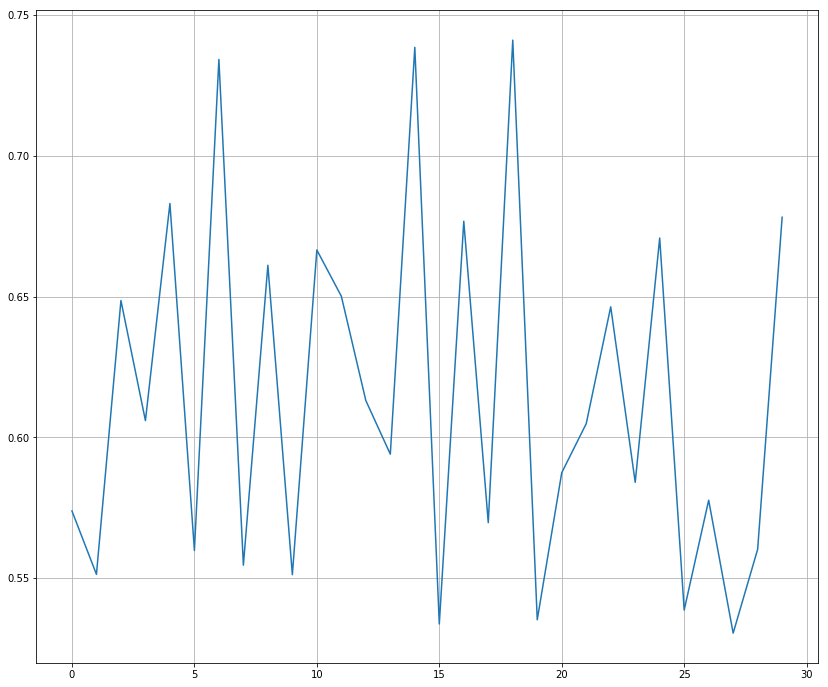

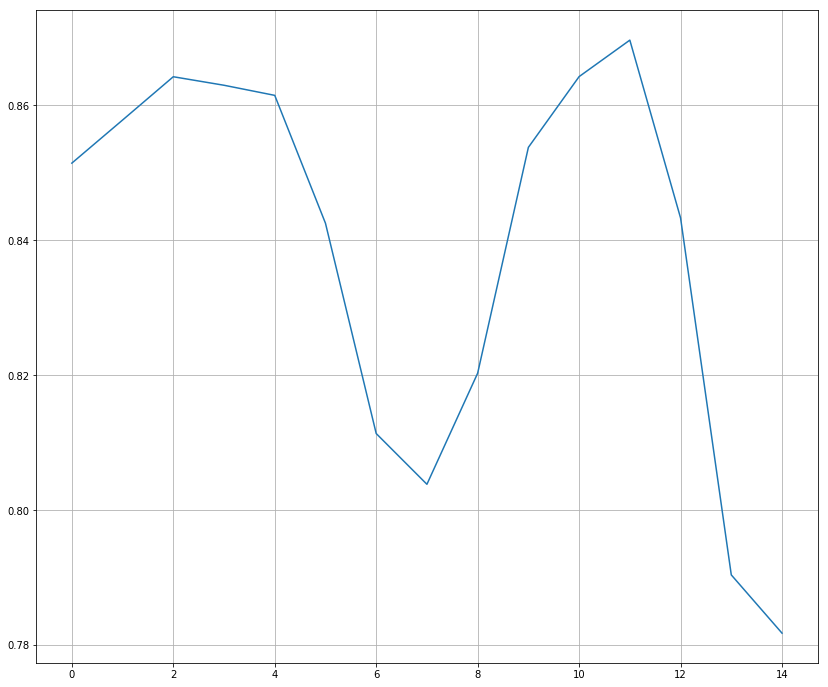

In [28]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 12))
plt.plot(metrics.train['loss'])
plt.grid()
plt.figure(figsize=(14, 12))
plt.plot(metrics.test['loss'])
plt.grid()

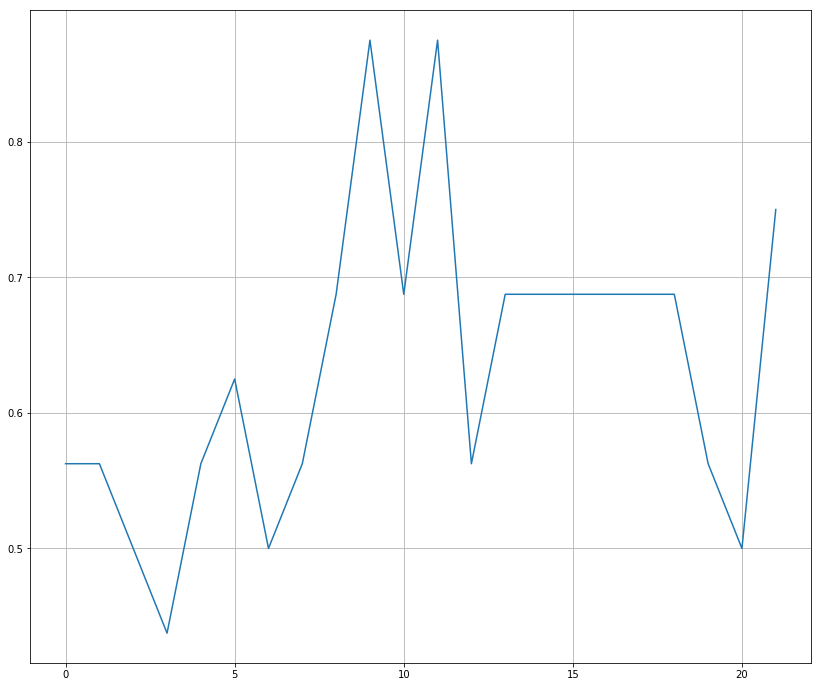

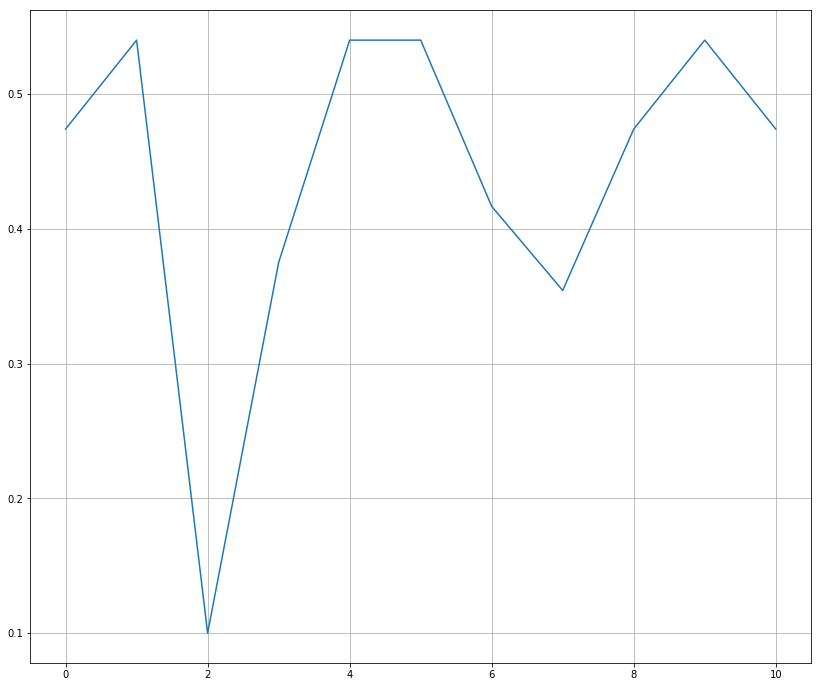

In [21]:
plt.figure(figsize=(14, 12))
plt.plot(metrics.train['f1'])
plt.grid()
plt.figure(figsize=(14, 12))
plt.plot(metrics.test['f1'])
plt.grid()

In [85]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          